Anushna Prakash  
DATA 598: Deep Learning  
January 14, 2022  
# <center> Homework 1  
## Part I: Performance vs. Width

In this exercise, we will experiment with the number of hidden units in a multilayer perceptron (MLP) with a single hidden layer. The number of hidden units is also referred to the width of the hidden layer. Here are the details:  
- The setup is identical to the demo/lab and you may reuse that code. Take the FashionMNIST dataset and randomly subsample 10% of its training set to work with. As a test set, we will use the full test set of FashionMNIST.  
- Define a MLP with one hidden layer of width $h = 32$. Find the divergent learning rate $\eta ^*$ for this
model and use a fixed learning rate of $\eta^∗ / 2$, as we discussed in class.  
- Train the model for 100 passes over the data.  
- Repeat this procedure for widths $h = 8, 16, 128, 512$ with the same learning rate $\eta^∗ / 2$ as above (i.e., you do not need to find the divergent learning rate of each model for this exercise).  

The deliverables for this exercise are:  
1. Make 4 plots, one each for the train loss, train accuracy, test loss and test accuracy over the course of training (i.e., the metric on the y-axis and number of effective passes on the x-axis). Plot all 4 lines, one for each value of h on the same plot.  
2. When the training accuracy is 100%, the model is said to interpolate the training data. What is the smallest width at which we observe perfect interpolation of the training data?  
3. As we vary the width of the network, at which training epoch do we observe perfect interpolation of the data? That is, make a plot with h on the x-axis and number of passes over the data required for interpolation on the y axis.  

Some notes for broader context:  
- For the full dataset, we can make the same observation, but the smallest width of the network which can perfectly interpolate the training data is much larger.  
- While networks of a range of widths can perfectly interpolate the training data, the test errors they obtain can be different. This is one of the observations that makes tuning a neural network architecture more of an art than a science.  
- A general rule of thumb is that the neural network should be large enough to interpolate the training data.  

In [1]:
# Imports
import numpy as np
import torch
from torchvision.datasets import FashionMNIST
from torch.nn.functional import cross_entropy
import time

import matplotlib.pyplot as plt 
%matplotlib inline 

torch.manual_seed(0)
np.random.seed(1)

Download the FashionMNIST training and test data. Randomly select 10% of the full training data set to train on. Use full test set.

In [2]:
# Randomly subset 10% of the FashionMNIST training data
# download dataset (~117M in size)
train = FashionMNIST('./data', train=True, download=True)
X_train = train.data
y_train = train.targets.long()
test = FashionMNIST('./data', train=False, download=True)
X_test = test.data
y_test = test.targets.long()

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10))
X_train, y_train = X_train[idxs_train], y_train[idxs_train]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


Preprocessing: Normalize the training set and flatten from $28 x 28$ to 784 pixels long.

In [3]:
RESHAPE_SIZE = X_train.shape[1:][0] * X_train.shape[1:][1] # 784
X_train = X_train.float().view(-1, RESHAPE_SIZE)  # Shape: (n, 784)

# Normalize: add a small number to avoid divide by zero
mean, std = X_train.mean(axis=0), X_train.std(axis=0)  # Shape: (784,)
X_train = (X_train - mean[None, :]) / (std[None, :] + 1e-6) # Shape: (n, 784)

X_test = X_test.float().view(-1, RESHAPE_SIZE)  # Shape: (n', 784)
X_test = (X_test - mean[None, :]) / (std[None, :] + 1e-6)  # Shape: (n', 784)

n_class = np.unique(y_train).shape[0]  # We have K=10 classes numbered (0, 1, ..., 9)

Create MLP with one hidden layer with width $h = 32$.

`mlp` function is computing  
$$
    \varphi(x; W_1, \cdots, W_L, b_1, \cdots, b_L) = 
    W_L^\top \sigma\Big( W_{L-1}^\top \sigma\big( \cdots \sigma(W_1^\top x + b_1)\big) + b_{L-1} \Big) + b_L
$$  
with $\sigma (t) = max[t, 0]$.

In [4]:
# Create utility functions to compute objective and accuracy

def mlp(X, ws, bs):
    """
    Compute multi-layered perceptron with one hidden layer
    X is shape (n, d)
    ws is list of tensors of consistent shape
    Uses RELU for activation function.
    """
    hidden = X #n(, d_0)
    for w, b in zip(ws[:-1], bs[:-1]):
        hidden = torch.matmul(hidden, w) + b[None, :]
        hidden = torch.nn.functional.relu(hidden)
    return torch.matmul(hidden, ws[-1]) + bs[-1][None, :] # why only using -1 index?

def compute_objective(ws, bs, X, y, reg_param):
    """
    Compute multinomial logistic loss.
    ws is list of tensors with consistent shape
    X is of shape (n, d) and y is shape (n,)
    """
    score = mlp(X, ws, bs) # Shape: (n, K)
    return (
        cross_entropy(input=score, target=y, reduction='mean') 
        + 0.5 * reg_param * sum([torch.norm(w)**2 for w in ws])
    )

@torch.no_grad()
def compute_accuracy(ws, bs, X, y):
    """
    Compute the classification accuracy.
    ws is a list of tensors of consistent shape.
    X is of shape (n, d) and y is of shape (n,)
    """
    score = mlp(X, ws, bs)
    predictions = torch.argmax(score, axis=1) # predict class with the highest score
    return (predictions == y).sum() * 1.0 / y.shape[0]

@torch.no_grad()
def compute_logs(ws, bs, reg_param, verbose=False):
    """
    """
    train_loss = compute_objective(ws, bs, X_train, y_train, reg_param)
    test_loss = compute_objective(ws, bs, X_test, y_test, reg_param)
    train_accuracy = compute_accuracy(ws, bs, X_train, y_train)
    test_accuracy = compute_accuracy(ws, bs, X_test, y_test)
    
    if verbose:
        print(
            ('Train loss = {:.3f}, Train accuracy = {:.3f}, ' + 
             'Test loss = {:.3f}, Test accuracy = {:.3f}').format(
                train_loss.item(), train_accuracy.item(),
                test_loss.item(), test_accuracy.item())
        )
    return (train_loss, train_accuracy, test_loss, test_accuracy)

def sgd_one_pass(ws, bs, X, y, reg_param, learning_rate, verbose=False):
    """
    One pass of stochastic gradient descent
    """
    num_examples = X.shape[0]
    average_loss = 0.0
    for i in range(num_examples):
        idx = np.random.choice(X.shape[0])
        
        # Compute the objective
        # Note: This function requires X to be of shape (n, d). In this case n=1.
        objective = compute_objective(ws, bs, X[idx:idx+1], y[idx:idx+1], reg_param)
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        
        if verbose and (i+1) % 100 == 0:
            print(average_loss)
            
        # Compute the gradient using automatic differentiation
        all_parameters = [*ws, *bs]
        gradients = torch.autograd.grad(outputs=objective, inputs=all_parameters)
        
        # Perform SGD update. MAKE THE UPDATE INPLACE
        with torch.no_grad():
            for (w, g) in zip(all_parameters, gradients):
                w -= learning_rate * g
        
    return ws, bs

Start with $\eta=0.1$ to find the divergent learning rate. (This diverges)

In [5]:
reg_param = 0.0
hidden_size = 32

# Find optimal learning_rate
learning_rate = 1e-1

logs = []
# Randomize start of weights
ws = [1e-6 * torch.randn(RESHAPE_SIZE, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
# No bias
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train loss = 2.303, Train accuracy = 0.094, Test loss = 2.303, Test accuracy = 0.096
62.190763311322456
4650229904738404.0
8.93262588471546e+29
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
Train loss = nan, Train accuracy = 0.098, Test loss = nan, Test accuracy = 0.100


Update to $\eta=0.01$. This converges!

In [6]:
reg_param = 0.0
hidden_size = 32

# Find optimal learning_rate
learning_rate = 1e-2

logs = []
# Randomize start of weights
ws = [1e-6 * torch.randn(RESHAPE_SIZE, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
# No bias
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train loss = 2.303, Train accuracy = 0.052, Test loss = 2.303, Test accuracy = 0.051
1.4608998256816126
1.9923951213840163
2.1889454314199206
2.2640533873590174
2.2909573200380366
2.2916773653685953
2.1414728888739516
1.8798762360914671
1.6420133585703154
1.5075974727856454
1.3210117978532534
1.2342914046561744
1.1181583890333024
0.9726298808026117
0.8707886463612109
0.79226330957119
0.8577001934259665
0.9085297572757587
0.8122739152289604
0.834719401049695
0.731862613892723
0.8407149233663985
0.908821499570108
0.7285062533028129
0.5984741258662986
0.597750551638531
0.6075865823842667
1.0735915624737125
0.899249244420615
0.7333176383869785
0.7219997470497812
0.7305460816789218
0.8116702203496948
0.8059350258556143
0.6905435382657853
0.6735241816981435
0.5869940299452227
0.5497299399154231
0.8656895033968851
0.8230686231384952
0.8478453928882861
0.7543565825809772
0.6816981395657867
0.7355536919599106
0.5692651553372777
0.6254473785115257
0.5855207601357346
0.6584080455105329
0.79357444

$2*\eta$ diverges. This makes the divergent learning rate $\eta=0.01$.

In [7]:
reg_param = 0.0
hidden_size = 32

# Find optimal learning_rate
learning_rate = 2e-2

logs = []
# Randomize start of weights
ws = [1e-6 * torch.randn(RESHAPE_SIZE, hidden_size, requires_grad=True),
      1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
# No bias
bs = [torch.zeros(hidden_size, requires_grad=True),
      torch.zeros(n_class, requires_grad=True)]

_ = compute_logs(ws, bs, reg_param, verbose=True)

ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=True)
_ = compute_logs(ws, bs, reg_param, verbose=True)

Train loss = 2.303, Train accuracy = 0.080, Test loss = 2.303, Test accuracy = 0.079
1.4564269354584076
1.995417965629625
2.1310496323388772
2.016373012374918
1.7532089025766102
1.5139263438459274
1.3836902138532827
1.288920363325558
1.2262919844425402
1.3574690307865898
1.2204098321357535
1.2131959498940585
1.0360843641254396
1.1388596518940128
1.3927669974371546
1.0990790746918158
1.277246767612214
1.4308077213127042
1.2053607266189228
1.1023092795417997
1.3862985395961507
1.6492444269042688
1.422250738767373
1.3128419238697802
1.2442829735233365
1.1770806143899668
1.2541262081164963
0.9667243504955382
1.279898388822276
1.2761362769329243
1.4547387579912916
1.1066895717598637
1.1241894677800555
1.6672457091373019
1.2063193238719538
2.1327376819989388
2.58623868011221
2.212351041489525
2.4420904460214206
2.2242393061174552
2.2269066207917607
2.469038300907245
2.3275872827818325
1.8794025854595273
1.6657704713313684
1.971801793644813
2.1387933799231056
1.877628481474048
1.5793825792636

Using $\eta^* = 0.01$ and fixing the learning rate at $\frac{\eta^*}{2}=0.005$, train the model on 100 passes of the data for $h=8, 16, 32, 64, 128, 512$.

In [9]:
def train_mlp_model(reg_param, hidden_size, learning_rate, iterations):
    """
    Outputs a list of the compute logs for the model
    """
    logs = []
    ws = [1e-6 * torch.randn(RESHAPE_SIZE, hidden_size, requires_grad=True),
          1e-6 * torch.randn(hidden_size, n_class, requires_grad=True)]
    bs = [torch.zeros(hidden_size, requires_grad=True),
          torch.zeros(n_class, requires_grad=True)]
    logs.append(compute_logs(ws, bs, reg_param, verbose=True))

    for j in range(iterations):
        print(j+1, end=', ')
        ws, bs = sgd_one_pass(ws, bs, X_train, y_train, reg_param, learning_rate, verbose=False)
        logs.append(compute_logs(ws, bs, reg_param, verbose=False))
    return logs

### Deliverable 1: Plot training/test loss and accuracy for each network width

Train loss = 2.303, Train accuracy = 0.114, Test loss = 2.303, Test accuracy = 0.111
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, Train loss = 2.303, Train accuracy = 0.102, Test loss = 2.303, Test accuracy = 0.098
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, Train loss = 2.303, Train accuracy = 0.157, Te

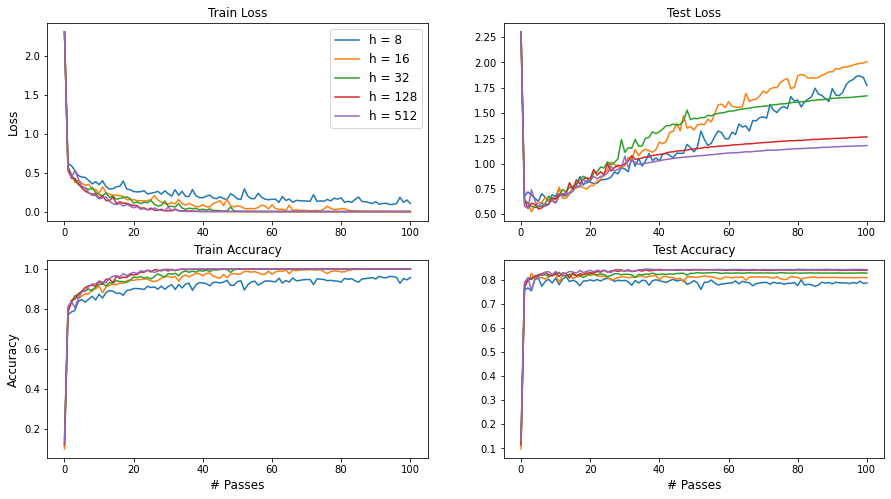

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
logs = []
reg_param = 0.0
LEARNING_RATE = 5e-3

for h in [8, 16, 32, 128, 512]:
    # Train model
    log = np.asarray(train_mlp_model(reg_param, h, LEARNING_RATE, 100))
    logs.append(log)
#     log = np.asarray(log)
#     log = np.asarray(logs)
    h_lab = 'h = ' + str(h)
    
    # Plot results
    ax[0][0].plot(log[:, 0], label=h_lab)
    ax[0][1].plot(log[:, 2], label=h_lab)
    ax[1][0].plot(log[:, 1], label=h_lab)
    ax[1][1].plot(log[:, 3], label=h_lab)

ax[1][1].set_xlabel('# Passes', fontsize=12)
ax[1][0].set_xlabel('# Passes', fontsize=12)
ax[0][0].set_ylabel('Loss', fontsize=12)
ax[1][0].set_ylabel('Accuracy', fontsize=12)
ax[0][0].set_title('Train Loss', fontsize=12)
ax[0][1].set_title('Test Loss', fontsize=12)
ax[1][0].set_title('Train Accuracy', fontsize=12)
ax[1][1].set_title('Test Accuracy', fontsize=12)
ax[0][0].legend(fontsize=12)

### Deliverable 2: What is the smallest $h$ for which we see interpolation? That is $h=32$.

In [46]:
def get_min_epoch(i):
    if i.size == 0:
        return None
    else:
        return np.min(i)

min_epoch = [get_min_epoch(np.where(l[:, 1] == 1.0)[0]) for l in logs]
epochs = {'h': [8, 16, 32, 128, 512],
          'min_epoch': min_epoch}
print(epochs)

{'h': [8, 16, 32, 128, 512], 'min_epoch': [None, None, 53, 41, 34]}


### Deliverable 3: The minimum number of passes needed to perfectly interpolate the data decreases as the network width increases.  
For $h=32$ it is 53 passes, and for $h=512$ it is 34 passes.

Text(0.5, 1.0, 'Min number of passes to interpolate vs. network width')

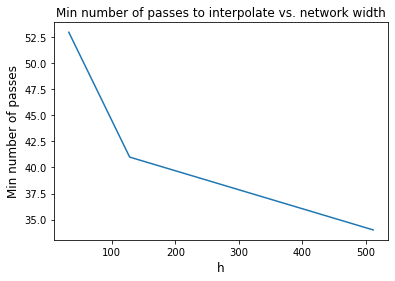

In [54]:
plt.plot(figsize=(15, 8))

plt.plot(epochs['h'], epochs['min_epoch'])
plt.xlabel('h', fontsize=12)
plt.ylabel('Min number of passes', fontsize=12)
plt.title('Min number of passes to interpolate vs. network width', fontsize=12)